# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [3]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train(True)
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (data, target) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        model_out = model(data)
        
        # TODO: compute negative log likelihood loss
        criterion = nn.NLLLoss()
        
        # TODO: do backpropagation
        loss = criterion(model_out, target)
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print('\nCurrent loss for epoch: {}\tLoss: {}'.format(epoch, loss.item()))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [5]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__() #call constructor of basis class nn.Module
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.layer1 = nn.Linear(784,200) #fully connected because input number of node i+1 is output number of node i
        self.layer2 = nn.Linear(200, 100)
        self.layer3 = nn.Linear(100, 60)
        self.layer4 = nn.Linear(60, 30)
        self.layer5 = nn.Linear(30,10)

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run network layers
        x = F.sigmoid(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        x = F.sigmoid(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        x = self.layer5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)
        
        return output

In [6]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        self.layer1 = nn.Linear(784,200)
        self.layer2 = nn.Linear(200, 100)
        self.layer3 = nn.Linear(100, 60)
        self.layer4 = nn.Linear(60, 30)
        self.layer5 = nn.Linear(30,10)
        
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run network layers
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [7]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        self.layer1 = nn.Sequential(nn.BatchNorm1d(784), nn.Linear(784,200))
        self.layer2 = nn.Linear(200, 100)
        self.layer3 = nn.Sequential(nn.BatchNorm1d(100), nn.Linear(100, 60))
        self.layer4 = nn.Linear(60, 30)
        self.layer5 = nn.Linear(30,10)
        
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run network layers
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [8]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3 ), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU())
        self.layer3 = nn.Linear(64*12*12, 128)
        self.layer4 = nn.Linear(128,10)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [9]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.layer1 = nn.Sequential(nn.BatchNorm2d(1),nn.Conv2d(1, 32, kernel_size=3), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU())
        self.layer3 = nn.Sequential(nn.BatchNorm1d(64*12*12), nn.Linear(64*12*12, 128), nn.ReLU())
        self.layer4 = nn.Linear(128,10)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.layer3(x)
        x = F.relu(self.layer4(x))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

In [10]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        # TODO: initialize network layers
        self.layer1 = nn.Sequential(nn.BatchNorm2d(1), nn.Conv2d(1, 32, kernel_size=3), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.BatchNorm1d(64*12*12), nn.Linear(64*12*12, 128))
        self.layer4 = nn.Linear(128,10)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.reshape(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        return output

C:\Users\Sunny\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Current loss for epoch: 1	Loss: 2.311293840408325

Current loss for epoch: 1	Loss: 0.29084649682044983

Current loss for epoch: 1	Loss: 0.37600505352020264

Current loss for epoch: 1	Loss: 0.1997309774160385

Current loss for epoch: 1	Loss: 0.2590508759021759

Current loss for epoch: 1	Loss: 0.2225332111120224

Current loss for epoch: 1	Loss: 0.16093584895133972

Current loss for epoch: 1	Loss: 0.20040683448314667

Current loss for epoch: 1	Loss: 0.06229011341929436

Current loss for epoch: 1	Loss: 0.07945193350315094

Test set: Average loss: 0.1362, Accuracy: 9599/10000 (95.99%)



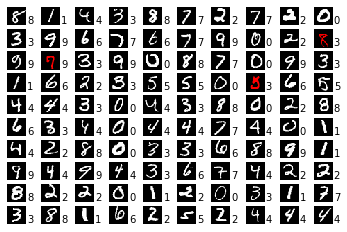


Current loss for epoch: 2	Loss: 0.16539226472377777

Current loss for epoch: 2	Loss: 0.05326548591256142

Current loss for epoch: 2	Loss: 0.009866919368505478

Current loss for epoch: 2	Loss: 0.046882402151823044

Current loss for epoch: 2	Loss: 0.017866535112261772

Current loss for epoch: 2	Loss: 0.1492081880569458

Current loss for epoch: 2	Loss: 0.04097727686166763

Current loss for epoch: 2	Loss: 0.045281972736120224

Current loss for epoch: 2	Loss: 0.19036956131458282

Current loss for epoch: 2	Loss: 0.014433963224291801

Test set: Average loss: 0.0867, Accuracy: 9753/10000 (97.53%)



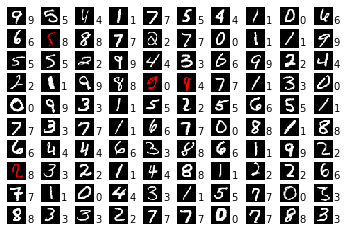


Current loss for epoch: 3	Loss: 0.016259506344795227

Current loss for epoch: 3	Loss: 0.03801264613866806

Current loss for epoch: 3	Loss: 0.031366389244794846

Current loss for epoch: 3	Loss: 0.028346896171569824

Current loss for epoch: 3	Loss: 0.045206889510154724

Current loss for epoch: 3	Loss: 0.006987200118601322

Current loss for epoch: 3	Loss: 0.006919655948877335

Current loss for epoch: 3	Loss: 0.06434217095375061

Current loss for epoch: 3	Loss: 0.28224673867225647

Current loss for epoch: 3	Loss: 0.0020381214562803507

Test set: Average loss: 0.0805, Accuracy: 9781/10000 (97.81%)



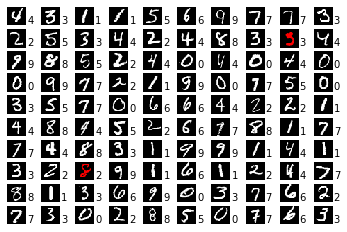


Current loss for epoch: 4	Loss: 0.00382659281603992

Current loss for epoch: 4	Loss: 0.005315086804330349

Current loss for epoch: 4	Loss: 0.0767136961221695

Current loss for epoch: 4	Loss: 0.004143708385527134

Current loss for epoch: 4	Loss: 0.07166571915149689

Current loss for epoch: 4	Loss: 0.0307763759046793

Current loss for epoch: 4	Loss: 0.0018932707607746124

Current loss for epoch: 4	Loss: 0.005194925703108311

Current loss for epoch: 4	Loss: 0.029215974733233452

Current loss for epoch: 4	Loss: 0.058630093932151794

Test set: Average loss: 0.0753, Accuracy: 9810/10000 (98.10%)



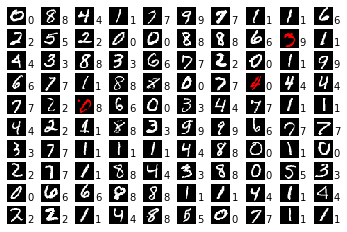


Current loss for epoch: 5	Loss: 0.008611859753727913

Current loss for epoch: 5	Loss: 0.010172108188271523

Current loss for epoch: 5	Loss: 0.00647202180698514

Current loss for epoch: 5	Loss: 0.0006280962843447924

Current loss for epoch: 5	Loss: 0.004663483705371618

Current loss for epoch: 5	Loss: 0.020875323563814163

Current loss for epoch: 5	Loss: 0.004810748156160116

Current loss for epoch: 5	Loss: 0.013913530856370926

Current loss for epoch: 5	Loss: 0.01595454476773739

Current loss for epoch: 5	Loss: 0.001928112469613552

Test set: Average loss: 0.0773, Accuracy: 9815/10000 (98.15%)



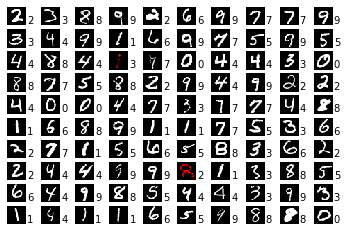


Current loss for epoch: 6	Loss: 0.0030063919257372618

Current loss for epoch: 6	Loss: 0.0071366578340530396

Current loss for epoch: 6	Loss: 0.028832923620939255

Current loss for epoch: 6	Loss: 0.004353633150458336

Current loss for epoch: 6	Loss: 0.004644423257559538

Current loss for epoch: 6	Loss: 0.013899510726332664

Current loss for epoch: 6	Loss: 0.0031191196758300066

Current loss for epoch: 6	Loss: 0.0018421063432469964

Current loss for epoch: 6	Loss: 0.0012964463094249368

Current loss for epoch: 6	Loss: 0.0004461005446501076

Test set: Average loss: 0.0805, Accuracy: 9828/10000 (98.28%)



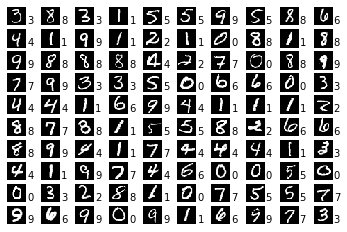


Current loss for epoch: 7	Loss: 0.006666677538305521

Current loss for epoch: 7	Loss: 0.003916760440915823

Current loss for epoch: 7	Loss: 0.0004283067537471652

Current loss for epoch: 7	Loss: 0.1429690718650818

Current loss for epoch: 7	Loss: 0.11748156696557999

Current loss for epoch: 7	Loss: 0.00027700531063601375

Current loss for epoch: 7	Loss: 0.0016133917961269617

Current loss for epoch: 7	Loss: 0.004540143068879843

Current loss for epoch: 7	Loss: 0.003889605635777116

Current loss for epoch: 7	Loss: 0.0015652112197130919

Test set: Average loss: 0.0846, Accuracy: 9830/10000 (98.30%)



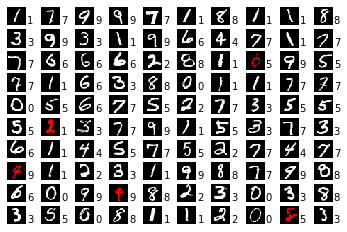


Current loss for epoch: 8	Loss: 0.0029477907810360193

Current loss for epoch: 8	Loss: 0.002410527318716049

Current loss for epoch: 8	Loss: 0.0031047272495925426

Current loss for epoch: 8	Loss: 0.021053889766335487

Current loss for epoch: 8	Loss: 0.004424868151545525

Current loss for epoch: 8	Loss: 0.001163952169008553

Current loss for epoch: 8	Loss: 0.11501583456993103

Current loss for epoch: 8	Loss: 0.0030101612210273743

Current loss for epoch: 8	Loss: 0.0013974419562146068

Current loss for epoch: 8	Loss: 0.0009878217242658138

Test set: Average loss: 0.0884, Accuracy: 9824/10000 (98.24%)



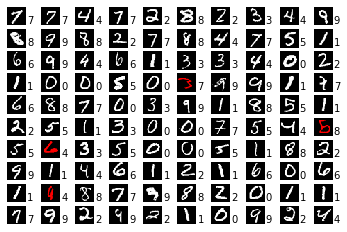


Current loss for epoch: 9	Loss: 0.0015545146306976676

Current loss for epoch: 9	Loss: 0.0010004795622080564

Current loss for epoch: 9	Loss: 0.0004269497294444591

Current loss for epoch: 9	Loss: 0.00037695394712500274

Current loss for epoch: 9	Loss: 0.0018503200262784958

Current loss for epoch: 9	Loss: 0.0003913033287972212

Current loss for epoch: 9	Loss: 0.001085889176465571

Current loss for epoch: 9	Loss: 0.0009266172419302166

Current loss for epoch: 9	Loss: 0.0005688692908734083

Current loss for epoch: 9	Loss: 0.003818277269601822

Test set: Average loss: 0.0896, Accuracy: 9829/10000 (98.29%)



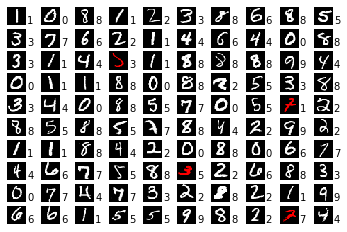


Current loss for epoch: 10	Loss: 0.00038408563705161214

Current loss for epoch: 10	Loss: 0.004398345481604338

Current loss for epoch: 10	Loss: 0.0007790691452100873

Current loss for epoch: 10	Loss: 0.001389649580232799

Current loss for epoch: 10	Loss: 0.00014525851293001324

Current loss for epoch: 10	Loss: 0.004074367228895426

Current loss for epoch: 10	Loss: 0.00013997113273944706

Current loss for epoch: 10	Loss: 0.08823385834693909

Current loss for epoch: 10	Loss: 0.002117566531524062

Current loss for epoch: 10	Loss: 0.0006514716660603881

Test set: Average loss: 0.0909, Accuracy: 9829/10000 (98.29%)



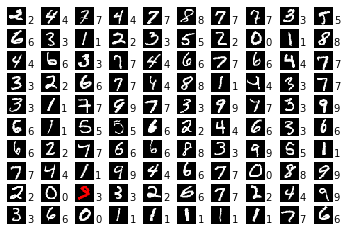

In [11]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")